In [10]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import brentq
import matplotlib.pyplot as plt

# --- 1. Physical Constants (SI Units) ---
G = 6.67430e-11        # Gravitational constant
c = 2.99792458e8         # Speed of light
M_sun = 1.989e30         # Mass of the sun in kg
RHO_NUC = 2.7e17         # Nuclear saturation density (kg/m^3)

In [11]:
# --- 2. The Low-Density "Crust" EoS ---
# Physically-correct constants
CRUST_GAMMA = 1.58425
CRUST_K = 1.0557e5
RHO_STITCH = 0.5 * RHO_NUC

def crust_eos(rho):
    """Calculates pressure from density for the low-density crust."""
    return CRUST_K * rho**CRUST_GAMMA

def inverse_crust_eos(P):
    """Calculates density from pressure for the low-density crust."""
    if P <= 0.0:
        return 0.0
    return (P / CRUST_K)**(1.0 / CRUST_GAMMA)

P_STITCH = crust_eos(RHO_STITCH)
print(f"Crust-Core Stitch Pressure (P_STITCH): {P_STITCH:.2e} Pa")

Crust-Core Stitch Pressure (P_STITCH): 1.45e+32 Pa


In [12]:
# --- 3. The Parameterized "Core" EoS (Piecewise Polytrope) ---
# This version is fast, robust, and guaranteed to be physically valid.

RHO_1 = 1.85 * RHO_NUC
RHO_2 = 3.7 * RHO_NUC
RHO_3 = 7.4 * RHO_NUC

LOG_RHO_STITCH = np.log(RHO_STITCH)
LOG_RHO_1 = np.log(RHO_1)
LOG_RHO_2 = np.log(RHO_2)
LOG_RHO_3 = np.log(RHO_3)

RHO_MAX = 20 * RHO_NUC
LOG_RHO_MAX = np.log(RHO_MAX)

def build_eos_from_params(params):
    """
    Builds EoS functions from [logP1, logP2, logP3] parameters.
    Returns eos_func, inverse_eos_func, and None for cs2_func.
    """
    logP1, logP2, logP3 = params
    P1 = 10**logP1
    P2 = 10**logP2
    P3 = 10**logP3

    log_rhos = np.array([LOG_RHO_STITCH, LOG_RHO_1, LOG_RHO_2, LOG_RHO_3])
    log_Ps = np.array([np.log(P_STITCH), np.log(P1), np.log(P2), np.log(P3)])

    gammas = (log_Ps[1:] - log_Ps[:-1]) / (log_rhos[1:] - log_rhos[:-1])
    gammas = np.append(gammas, [4.0])

    log_P_max = log_Ps[-1] + gammas[-1] * (LOG_RHO_MAX - log_rhos[-1])
    log_Ps = np.append(log_Ps, [log_P_max])
    log_rhos = np.append(log_rhos, [LOG_RHO_MAX])

    log_Ks = log_Ps[:-1] - gammas * log_rhos[:-1]

    def final_eos(rho):
        if rho < RHO_STITCH:
            return crust_eos(rho)
        if rho > RHO_MAX:
            rho = RHO_MAX

        log_rho = np.log(rho)

        if log_rho < LOG_RHO_1:
            log_P = log_Ks[0] + gammas[0] * log_rho
        elif log_rho < LOG_RHO_2:
            log_P = log_Ks[1] + gammas[1] * log_rho
        elif log_rho < LOG_RHO_3:
            log_P = log_Ks[2] + gammas[2] * log_rho
        else:
            log_P = log_Ks[3] + gammas[3] * log_rho

        return np.exp(log_P)

    def final_inverse_eos(P):
        if P < P_STITCH:
            return inverse_crust_eos(P)

        log_P = np.log(P)

        if log_P < np.log(P1):
            log_rho = (log_P - log_Ks[0]) / gammas[0]
        elif log_P < np.log(P2):
            log_rho = (log_P - log_Ks[1]) / gammas[1]
        elif log_P < np.log(P3):
            log_rho = (log_P - log_Ks[2]) / gammas[2]
        else:
            log_rho = (log_P - log_Ks[3]) / gammas[3]

        return np.exp(log_rho)

    # Return None for cs2_func as it's not needed
    return final_eos, final_inverse_eos, None

In [13]:
# --- 4. The SIMPLIFIED TOV Solver ---

def tov_solver(r, state, eos_func, inverse_eos_func):
    """
    Defines the simplified differential equations for Mass and Pressure.
    state = [M, P]
    """
    M, P = state

    if r < 1e-6: r = 1e-6

    denominator_term = (1 - 2 * G * M / (r * c**2))
    if denominator_term <= 0:
        return [0, 0]

    rho = inverse_eos_func(P)

    if rho <= 0 or P <= 0:
        return [0, 0]

    dMdr = 4 * np.pi * r**2 * rho

    term1_P = (rho + P / c**2) * (M + 4 * np.pi * r**3 * P / c**2)
    term2_P = r**2 * denominator_term
    dPdr = -G * term1_P / term2_P

    return [dMdr, dPdr]

def solve_for_central_density(rho_c, eos_func, inverse_eos_func, _cs2_func):
    """
    Solves the TOV equations for a single star using correct initial conditions.
    Returns the final Mass and Radius.
    (_cs2_func is ignored)
    """
    if rho_c <= 0: return 0, 0
    P_c = eos_func(rho_c)
    if P_c <= 0: return 0, 0
    epsilon_c = rho_c * c**2 # Needed for correct P_initial

    r_initial = 1e-6
    M_initial = (4.0/3.0) * np.pi * rho_c * r_initial**3
    P_initial = P_c - (2.0*np.pi*G/c**2) * (epsilon_c + P_c) * (epsilon_c/3.0 + P_c) * r_initial**2

    def surface(r, state, eos_func, inverse_eos_func):
        return state[1] - 1.0
    surface.terminal = True

    sol = solve_ivp(
        tov_solver,
        [r_initial, 30e3],
        [M_initial, P_initial], # Only solve for [M, P]
        args=(eos_func, inverse_eos_func),
        events=surface,
        method='RK45',
        rtol=1e-5
    )

    if not sol.success:
        # print(f"Solver failed at rho_c={rho_c:.2e}: {sol.message}")
        return 0, 0

    final_R = sol.t[-1]
    final_M = sol.y[0][-1]

    return final_M / M_sun, final_R / 1000.0

In [14]:
# --- 5. The Master "Engine" Function (Simplified) ---
def generate_observables(params):
    """
    This is the master function that the MCMC will call.
    It takes the EoS parameters and returns M_max and R_1.4.
    """
    logP1, logP2, logP3 = params

    try:
        eos_func, inverse_eos_func, cs2_func = build_eos_from_params(params)
    except (ValueError, OverflowError):
        return 0, 0

    central_densities = np.logspace(np.log10(RHO_NUC), np.log10(15 * RHO_NUC), 50)
    masses = []
    radii = []

    for rho_c in central_densities:
        M, R = solve_for_central_density(rho_c, eos_func, inverse_eos_func, cs2_func)
        if M > 0.1:
            masses.append(M)
            radii.append(R)

    if not masses:
        return 0, 0

    if len(masses) == 0:
        return 0, 0

    M_max = np.max(masses)

    if M_max < 2.01:
         return M_max, 0

    sort_idx = np.argsort(masses)
    masses_sorted = np.array(masses)[sort_idx]
    radii_sorted = np.array(radii)[sort_idx]

    unique_masses, unique_idx = np.unique(masses_sorted, return_index=True)

    if len(unique_masses) < 2:
        return M_max, 0

    R_1_4 = np.interp(1.4, unique_masses, radii_sorted[unique_idx])

    if np.isnan(R_1_4):
        return M_max, 0

    return M_max, R_1_4

In [15]:
# --- 6. Example Usage (for testing) ---
# This is a physically-stable set of parameters [logP1, logP2, logP3]
test_params = [33.79, 34.43, 35.56]

print(f"Testing with parameters: {test_params}")
M_max, R_1_4 = generate_observables(test_params)

print("--- Results ---")
print(f"Maximum Mass (M_sun): {M_max:.2f}")
print(f"Radius at 1.4 M_sun (km): {R_1_4:.2f}")

Testing with parameters: [33.79, 34.43, 35.56]
--- Results ---
Maximum Mass (M_sun): 2.89
Radius at 1.4 M_sun (km): 15.56


In [16]:
# --- 7. Phase 2: The Likelihood Function (Simplified) ---

def log_likelihood(params):
    """
    Calculates the log-likelihood for a given set of EoS parameters.
    'params' will be a list, e.g., [logP1, logP2, logP3]
    """

    # --- 1. Generate Model Predictions ---
    try:
        M_max, R_1_4 = generate_observables(params)
    except Exception as e:
        return -np.inf

    # --- 2. The Judge's First Cut (Priors) ---
    if M_max < 2.01:
        return -np.inf

    if R_1_4 == 0:
        return -np.inf

    logP1, logP2, logP3 = params
    if not (33.0 < logP1 < 35.0): return -np.inf
    if not (34.0 < logP2 < 35.5): return -np.inf
    if not (35.0 < logP3 < 36.5): return -np.inf

    # --- 3. The Judge's Scoring (The "Likelihood") ---

    # Evidence A: NICER Radius Measurement (PSR J0030+0451)
    chi2_nicer_j0030 = ((R_1_4 - 13.0)**2) / (1.2**2)

    # Evidence B: LIGO/Virgo Radius Constraint (from GW170817)
    # This is a radius constraint derived from the tidal deformability measurement
    chi2_ligo_radius = ((R_1_4 - 11.9)**2) / (1.4**2)

    # We removed the R_2.08 constraint for simplicity here.

    final_score = -0.5 * (chi2_nicer_j0030 + chi2_ligo_radius)

    return final_score

# --- Test the Likelihood Function ---
print("Testing the log_likelihood function...")
good_params = [33.79, 34.43, 35.56]

print(f"Score for good parameters: {log_likelihood(good_params):.2f}")

Testing the log_likelihood function...
Score for good parameters: -5.68


In [17]:
# --- 8. Phase 3: Run the MCMC Sampler ---
import numpy as np
import emcee
import time # To time the run

# MCMC setup
n_dim = 3  # Number of EoS parameters (logP1, logP2, logP3)
n_walkers = 50 # Number of MCMC "walkers" (should be > 2*n_dim)
n_burn = 50  # Number of "burn-in" steps to discard (let walkers find the peak)
n_steps = 100 # Number of actual sampling steps after burn-in

# Starting guess using the parameters we know work
initial_params = np.array([33.79, 34.43, 35.56])
# Initialize walkers in a tiny random ball around the initial guess
initial_pos = initial_params + 1e-4 * np.random.randn(n_walkers, n_dim)

print(f"Starting MCMC with {n_walkers} walkers...")
print(f"Burn-in steps: {n_burn}, Sampling steps: {n_steps}")
start_time = time.time()

# Set up the sampler
# We pass the number of walkers, dimensions, and our likelihood function
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_likelihood)

# Run the MCMC
# This is the main computation step. It will take time.
# The total steps run are burn-in + sampling steps.
sampler.run_mcmc(initial_pos, n_burn + n_steps, progress=True)

end_time = time.time()
total_minutes = (end_time - start_time) / 60.0
print(f"\n--- MCMC finished in {total_minutes:.1f} minutes ---")

Starting MCMC with 50 walkers...
Burn-in steps: 50, Sampling steps: 100


100%|██████████| 150/150 [57:04<00:00, 22.83s/it]


--- MCMC finished in 57.4 minutes ---


Shape of samples: (150, 50, 3)


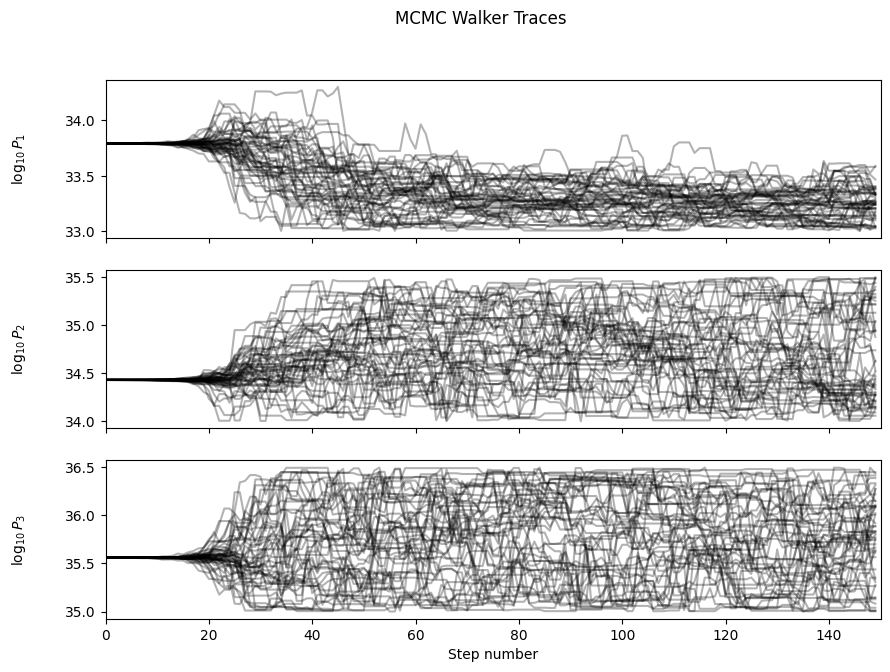

In [18]:
# --- 9. Phase 4.1: Check Convergence ---
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
# Get the full chain of samples from the sampler object
samples = sampler.get_chain()
labels = [r"$\log_{10} P_1$", r"$\log_{10} P_2$", r"$\log_{10} P_3$"]

print("Shape of samples:", samples.shape) # Should be (150 steps, 50 walkers, 3 params)

for i in range(3): # Loop over each parameter (logP1, logP2, logP3)
    ax = axes[i]
    # Plot the path of all 50 walkers for this parameter
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number");
plt.suptitle("MCMC Walker Traces")
plt.show()

Shape of flat_samples: (5000, 3)


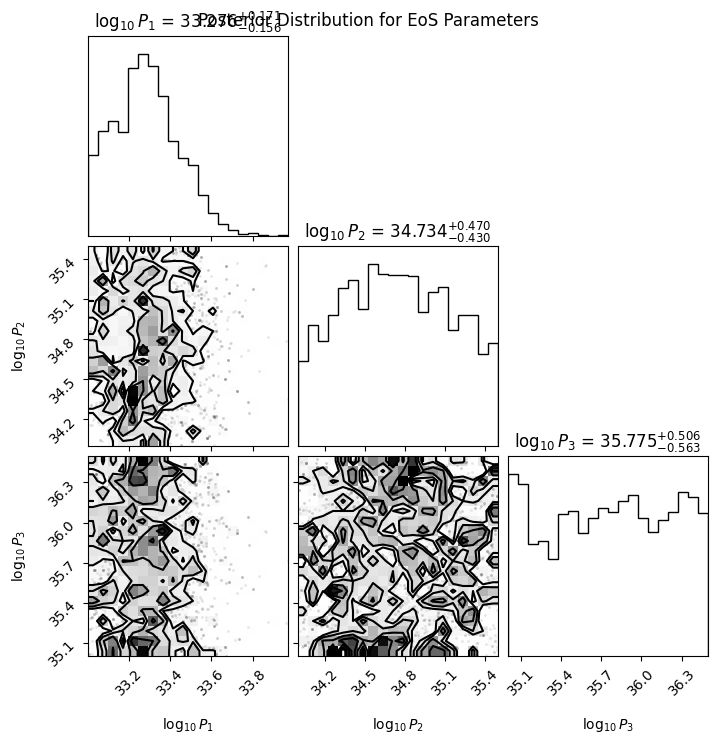

In [20]:
# --- 10. Phase 4.2: Corner Plot ---
import corner

# Get the samples, discarding the burn-in steps (first 50)
# and flatten the chains into a simple list of samples
flat_samples = sampler.get_chain(discard=50, flat=True)

print("Shape of flat_samples:", flat_samples.shape) # Should be (5000 samples, 3 params)

# Create the corner plot
fig = corner.corner(
    flat_samples, labels=labels, show_titles=True, title_fmt=".3f"
);
plt.suptitle("Posterior Distribution for EoS Parameters")
plt.show()

Generating M-R curves for posterior samples...


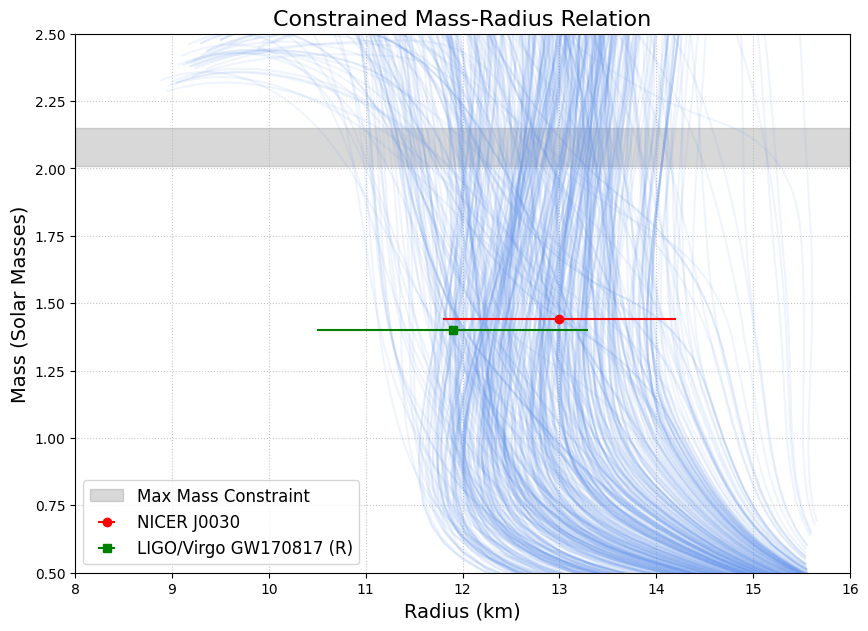

Credible band plot complete.


In [21]:
# --- 11. Phase 4.3: M-R Credible Band ---

print("Generating M-R curves for posterior samples...")

# Take a random subset of ~500 samples from the MCMC chain
# (using all 5000 can be slow to plot)
inds = np.random.randint(len(flat_samples), size=500)
sample_params = flat_samples[inds]

plt.figure(figsize=(10, 7))

# Loop through the random samples
for params in sample_params:
    try:
        # Generate the full M-R curve for this EoS
        eos_func, inverse_eos_func, _ = build_eos_from_params(params)
        central_densities_plot = np.logspace(np.log10(RHO_NUC), np.log10(15 * RHO_NUC), 100)
        masses_plot = []
        radii_plot = []
        for rho_c in central_densities_plot:
            M, R = solve_for_central_density(rho_c, eos_func, inverse_eos_func, None)
            if M > 0.1:
                masses_plot.append(M)
                radii_plot.append(R)
        
        # Plot this single M-R curve with high transparency
        if masses_plot: # Only plot if the solver succeeded
             plt.plot(radii_plot, masses_plot, color='cornflowerblue', alpha=0.1)

    except (ValueError, OverflowError):
        # Skip this sample if EoS building failed
        continue

# --- Add Observational Constraints ---
# NICER J0030 (Radius at 1.44 Msun)
plt.errorbar(13.0, 1.44, xerr=1.2, fmt='o', color='red', label='NICER J0030')
# LIGO/Virgo GW170817 (Radius at 1.4 Msun)
plt.errorbar(11.9, 1.4, xerr=1.4, fmt='s', color='green', label='LIGO/Virgo GW170817 (R)')
# Maximum Mass constraint (horizontal line)
plt.axhspan(2.01, 2.15, color='grey', alpha=0.3, label='Max Mass Constraint')

# --- Plot Formatting ---
plt.title('Constrained Mass-Radius Relation', fontsize=16)
plt.xlabel('Radius (km)', fontsize=14)
plt.ylabel('Mass (Solar Masses)', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
plt.xlim(8, 16)
plt.ylim(0.5, 2.5)
plt.show()

print("Credible band plot complete.")
